In [1]:
# Importing libraries
import pandas as pd
from preprocessing_utils import prepare_dataset
import numpy as np
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
from dataset import CheXpertDataset
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
import torch.nn as nn
from training_utils import train_model, upload_pretrained, upload_pretrained_vit
from torchsummary import summary
import torchvision.models as models
from tqdm.notebook import tqdm
import pickle

In [3]:
# Enable the widgets extension for JupyterLab
!jupyter labextension install @jupyter-widgets/jupyterlab-manager

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot

Jupyter command `jupyter-labextension` not found.


#### Constructing training dataset

In [2]:
# Import the train dataset
train_df = pd.read_csv('CheXpert-v1.0-small/train.csv')

# Define the class names for the medical conditions
class_names = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

# Define the policies for dataset preparation
policies = ['ones', 'zeroes', 'mixed']

# Prepare the dataset using the last policy in the list and the defined class names
image_paths, label_matrix = prepare_dataset(train_df, policies[-1], class_names)

# Create a DataFrame for the image paths
image_paths_df = pd.DataFrame({'path': image_paths})

# Create a DataFrame for the labels with the class names as columns
labels_df = pd.DataFrame(label_matrix, columns=class_names)

# Combine the image paths DataFrame and the labels DataFrame
train_df = pd.concat([image_paths_df, labels_df], axis=1)

In [3]:
# Print some information about the train DataFrame
# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)
display(train_df.head())
print("Number of rows and columns in the train DataFrame:", train_df.shape)
# Print the column names and their data types
print("Column names and data types:")
print(train_df.dtypes)

path  Atelectasis  \
0  CheXpert-v1.0-small/train/patient14619/study6/...            0   
1  CheXpert-v1.0-small/train/patient14869/study2/...            0   
2  CheXpert-v1.0-small/train/patient40881/study1/...            1   
3  CheXpert-v1.0-small/train/patient24862/study3/...            0   
4  CheXpert-v1.0-small/train/patient35268/study4/...            0   

   Cardiomegaly  Consolidation  Edema  Pleural Effusion  
0             0              0      0                 1  
1             0              0      1                 0  
2             0              0      0                 0  
3             0              0      0                 1  
4             1              0      1                 0

Number of rows and columns in the train DataFrame: (191027, 6)
Column names and data types:
path                object
Atelectasis          int64
Cardiomegaly         int64
Consolidation        int64
Edema                int64
Pleural Effusion     int64
dtype: object


#### Constructing validation dataset

In [4]:
# Import the validation dataset
valid_df = pd.read_csv('CheXpert-v1.0-small/valid.csv')

# Define the class names for the medical conditions
class_names = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

# Define the policies for dataset preparation
policies = ['ones', 'zeroes', 'mixed']

# Prepare the validation dataset using the last policy in the list and the defined class names
valid_image_paths, valid_label_matrix = prepare_dataset(valid_df, policies[-1], class_names)

# Create a DataFrame for the validation image paths
valid_image_paths_df = pd.DataFrame({'path': valid_image_paths})

# Create a DataFrame for the validation labels with the class names as columns
valid_labels_df = pd.DataFrame(valid_label_matrix, columns=class_names)

# Combine the validation image paths DataFrame and the validation labels DataFrame
valid_df = pd.concat([valid_image_paths_df, valid_labels_df], axis=1)

In [5]:
# Print some information about the train DataFrame
# Set pandas display options to show all columns
display(valid_df.head())
print("Number of rows and columns in the validation DataFrame:", valid_df.shape)
# Print the column names and their data types
print("Column names and data types:")
print(valid_df.dtypes)

path  Atelectasis  \
0  CheXpert-v1.0-small/valid/patient64735/study1/...            1   
1  CheXpert-v1.0-small/valid/patient64634/study1/...            0   
2  CheXpert-v1.0-small/valid/patient64712/study1/...            0   
3  CheXpert-v1.0-small/valid/patient64662/study1/...            0   
4  CheXpert-v1.0-small/valid/patient64578/study1/...            0   

   Cardiomegaly  Consolidation  Edema  Pleural Effusion  
0             0              0      0                 0  
1             0              0      0                 0  
2             1              0      1                 0  
3             0              0      0                 0  
4             0              0      0                 0

Number of rows and columns in the validation DataFrame: (202, 6)
Column names and data types:
path                object
Atelectasis          int64
Cardiomegaly         int64
Consolidation        int64
Edema                int64
Pleural Effusion     int64
dtype: object


#### Dataset formation according to torch (using dataloaders)

In [6]:
# Define the transformation pipeline for the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale images
])

# Define the class names for the medical conditions
class_names = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']

# Create the training dataset with the defined transformations
train_dataset = CheXpertDataset(train_df, class_names, transform=transform)

# Create the validation dataset with the defined transformations
valid_dataset = CheXpertDataset(valid_df, class_names, transform=transform)

# Create DataLoader for the training dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create DataLoader for the validation dataset
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

# Verify data loading by fetching a batch of images and labels from the training DataLoader
images, labels = next(iter(train_loader))

#### Visualising example

In [7]:
# Fetch a batch of images and labels from the validation DataLoader
# test_X contains the images and test_Y contains the
# corresponding labels from the validation set
test_X, test_Y = next(iter(valid_loader))

Original shape: torch.Size([3, 224, 224]), New shape: (224, 224, 3)
Example image:


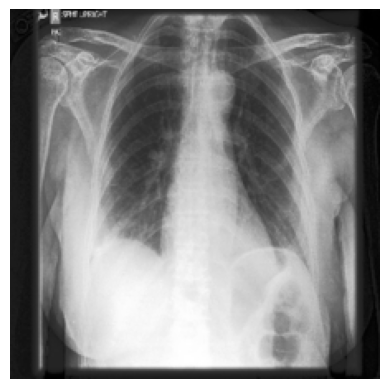

In [8]:
# Select the first image in the batch
image = test_X[0]
original_shape = image.shape
image = image.permute(1, 2, 0).numpy()  # Change shape to (224, 224, 3)
new_shape = image.shape
print(f"Original shape: {original_shape}, New shape: {new_shape}")
# Check the shape of the image to ensure it is (224, 224, 3)
assert new_shape == (224, 224, 3), f"Expected shape (224, 224, 3), but got {image.shape}"

# Denormalize the image for visualization
image = (image * 0.5) + 0.5

# Plot the image
print("Example image:")
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

#### Here we can extract different pre-trained models (in the given example, Resnet18 and vision transformer).

In [9]:
# Load a pre-trained ResNet-18 model, add custom layers, and freeze certain layers
# 
# Parameters:
# - pretrained: Use a pre-trained version of ResNet-18
# - add_layers: Add custom layers to the model
# - n_labels: Number of output labels (classes)
# - freeze_layers: Freeze the layers of the pre-trained model to prevent them from being updated during training
model_resnet = upload_pretrained(
    models.resnet18(pretrained=True),  # Load a pre-trained ResNet-18 model
    add_layers=True,                   # Add custom layers to the model
    n_labels=5,                        # Set the number of output labels (classes) to 5
    freeze_layers=True                 # Freeze the layers of the pre-trained model
)

/opt/anaconda3/envs/xai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/xai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


##### Moreover, we can see summary of a model

In [24]:
# Get a model summary for ViT with input size (1, 3, 384, 384)
summary(model_resnet, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
         MaxPool2d-2         [-1, 16, 112, 112]               0
            Conv2d-3         [-1, 32, 112, 112]           4,640
         MaxPool2d-4           [-1, 32, 56, 56]               0
            Linear-5                  [-1, 128]      12,845,184
            Linear-6                    [-1, 5]             645
Total params: 12,850,917
Trainable params: 12,850,917
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 11.49
Params size (MB): 49.02
Estimated Total Size (MB): 61.08
----------------------------------------------------------------


#### Here is how we train the model

In [ ]:
# Define the loss function
# BCEWithLogitsLoss combines a Sigmoid layer and the BCELoss in one single class
criterion = nn.BCEWithLogitsLoss()

# Define the optimizer
# Adam optimizer with learning rate of 0.001
optimizer_resnet = optim.Adam(model_resnet.parameters(), lr=0.001)

# Train the model
# Parameters:
# - model: The model to be trained (ResNet-18 in this case)
# - train_loader: DataLoader for the training dataset
# - test_loader: DataLoader for the validation dataset
# - criterion: The loss function
# - optimizer: The optimizer
# - num_epochs: Number of epochs to train the model
# - device: Device to train the model on ('cpu' or 'cuda')
# - save_filename: Filename to save the trained model
train_losses_resnet, train_accuracies_resnet, test_losses_resnet, test_accuracies_resnet = train_model(
    model=model_resnet,
    train_loader=train_loader,
    test_loader=valid_loader,
    criterion=criterion,
    optimizer=optimizer_resnet,
    num_epochs=20,
    device='cpu',
    save_filename='model_resnet.pth'
)

Epoch 1/20:   0%|          | 0/5970 [00:00<?, ?batch/s]

### Pickle the trained model

In [ ]:
# Save the trained model using pickle
with open('model_resnet.pkl', 'wb') as f:
    pickle.dump(model_resnet, f)

print("Model saved as model_resnet.pkl")

### Load the trained model

In [ ]:
with open('model_resnet.pkl', 'rb') as f:
    loaded_model_resnet = pickle.load(f)

print("Model loaded from model_resnet.pkl")

In [ ]:
from shapely.geometry import Point
from typing import List, Tuple
import math

def find_open_endpoints_explicit(lines: List[Tuple[int, int, int, int, str]],
                                 tolerance: float = 5.0) -> List[Tuple[int, int]]:
    """
    For each endpoint of every line, check if that endpoint is within a given tolerance
    of any endpoint of any other line.
    Returns a list of endpoints (as (x, y)) that are not connected
    (i.e. they don't have any other endpoint within the tolerance).
    """
    open_points = []
    # For each line in the list...
    for line in lines:
        # Create two Point objects for its endpoints.
        pt1 = Point(line[0], line[1])
        pt2 = Point(line[2], line[3])
        pt1_connected = False
        pt2_connected = False
        # Compare these endpoints against the endpoints of every other line.
        for other in lines:
            if other == line:
                continue  # Skip the same line
            other_pt1 = Point(other[0], other[1])
            other_pt2 = Point(other[2], other[3])
            # Check pt1 against both endpoints of the other line.
            if pt1.distance(other_pt1) <= tolerance or pt1.distance(other_pt2) <= tolerance:
                pt1_connected = True
            # Check pt2 against both endpoints of the other line.
            if pt2.distance(other_pt1) <= tolerance or pt2.distance(other_pt2) <= tolerance:
                pt2_connected = True
            if pt1_connected and pt2_connected:
                break
        if not pt1_connected:
            open_points.append((line[0], line[1]))
        if not pt2_connected:
            open_points.append((line[2], line[3]))
    # Remove duplicates
    return list(set(open_points))

def euclidean_distance(p1: Tuple[int, int], p2: Tuple[int, int]) -> float:
    """Helper function to compute Euclidean distance between two 2D points."""
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def bridge_open_endpoints_auto(lines: List[Tuple[int, int, int, int, str]],
                               tolerance: float = 5.0,
                               max_bridge_distance: float = None) -> List[Tuple[int, int, int, int, str]]:
    """
    Automatically finds open endpoints from the list of lines and bridges them.
    
    If exactly two open endpoints are found, the function bridges them (as in your original code).
    If more than two are found, it uses a greedy minimal-distance pairing, bridging only pairs whose
    separation is less than or equal to max_bridge_distance. If max_bridge_distance is not set,
    it defaults to 2 * tolerance.
    
    Returns an updated list of lines including the bridging line(s).
    """
    # Find open endpoints using the explicit function
    open_points = find_open_endpoints_explicit(lines, tolerance)
    print("Found open endpoints:", open_points)
    
    if max_bridge_distance is None:
        max_bridge_distance = tolerance * 2  # a heuristic limit
    
    # If there are no open endpoints, or only one, there's nothing to do.
    if len(open_points) < 2:
        print("Not enough open endpoints to bridge.")
        return lines

    # For exactly two endpoints, simply bridge them.
    if len(open_points) == 2:
        p1, p2 = open_points
        # Determine the orientation
        if abs(p1[0] - p2[0]) <= tolerance:
            orientation = 'vertical (bridged)'
        elif abs(p1[1] - p2[1]) <= tolerance:
            orientation = 'horizontal (bridged)'
        else:
            orientation = 'diagonal (bridged)'
        bridging_line = (p1[0], p1[1], p2[0], p2[1], orientation)
        print(f"Bridging gap between {p1} and {p2} with {bridging_line}")
        lines.append(bridging_line)
        return lines

    # For more than two open endpoints, do a greedy pairing based on the minimal distance.
    # Build a list of all possible pairs (with their distances)
    pairs = []
    n = len(open_points)
    for i in range(n):
        for j in range(i + 1, n):
            d = euclidean_distance(open_points[i], open_points[j])
            pairs.append((d, i, j))
    # Sort pairs by distance
    pairs.sort(key=lambda x: x[0])

    # Greedily pair endpoints if they are not already paired and if the distance is acceptable.
    used = [False] * n
    bridging_pairs = []
    for d, i, j in pairs:
        if used[i] or used[j]:
            continue
        if d <= max_bridge_distance:
            bridging_pairs.append((open_points[i], open_points[j]))
            used[i] = True
            used[j] = True

    # Add bridging lines for each selected pair.
    for p1, p2 in bridging_pairs:
        if abs(p1[0] - p2[0]) <= tolerance:
            orientation = 'vertical (bridged)'
        elif abs(p1[1] - p2[1]) <= tolerance:
            orientation = 'horizontal (bridged)'
        else:
            orientation = 'diagonal (bridged)'
        bridging_line = (p1[0], p1[1], p2[0], p2[1], orientation)
        print(f"Bridging gap between {p1} and {p2} with {bridging_line}")
        lines.append(bridging_line)

    if not bridging_pairs:
        print("No pairs were close enough to bridge (max_bridge_distance = {}).".format(max_bridge_distance))
    return lines

# === Example Usage ===
# Imagine a nearly closed rectangle missing its top edge.
lines_info = [
    (100, 100, 100, 300, 'vertical'),    # left vertical
    (300, 100, 300, 300, 'vertical'),    # right vertical
    (100, 100, 300, 100, 'horizontal')   # bottom horizontal
    # Missing the top edge from (100,300) to (300,300)
]

# Use a tolerance that makes sense for your data.
# Here, if the gap is small, the function will find exactly 2 open endpoints;
# if there are more, it will try to pair them automatically.
updated_lines = bridge_open_endpoints_auto(lines_info, tolerance=12.0)

print("\nFinal Lines (including bridging line(s) if added):")
for ln in updated_lines:
    print(ln)
